In [3]:
# Importieren der erforderlichen Bibliotheken und Module
import os.path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mean_absolute_error
# Dateipfad zu den Metriken
labels_path = '/kaggle/input/appa-real-face-cropped/labels.csv'

# Explorative Datenanalyse

Was werden wir während der Datenexploration tun:

* Laden Sie die Daten und führen Sie eine Vorab-Bewertung durch, betrachten Sie die Größe der Stichprobe.
* Erstellen Sie ein Diagramm zur Altersverteilung in der Stichprobe.
* Zeigen Sie 10–15 Fotos auf dem Bildschirm an und betrachten Sie die Struktur des Datensatzes.
* Ziehen Sie Schlussfolgerungen darüber, wie die Forschungsergebnisse das Modelltraining beeinflussen werden.


****Laden der Daten****

In [4]:
# Verzeichnis mit Bildern
faces_path = '/kaggle/input/appa-real-face-cropped/final_files/final_files/'
# Laden der Metriken in einen DataFrame
df = pd.read_csv(labels_path)
# Inhalt überprüfen
df.sample(5)

,file_name,real_age
365,000365.jpg,33
4812,004812.jpg,20
5906,005907.jpg,24
3820,003820.jpg,39
7355,007377.jpg,41


In [5]:
# Überprüfen auf Duplikate
df['file_name'].duplicated().sum()

0

In [6]:
# Allgemeine Informationen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


# Beobachtungen:

1. Der Datenrahmen enthält 7951 Datensätze mit Dateinamen und Alterswerten.
2. Es gibt keine Datenlücken.
3. Keine Duplikate.

**Forschung**

In [7]:
# Statistiken anzeigen
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Das Mindestalter beträgt 1 Jahr, das Höchstalter beträgt 100 Jahre. Das Durchschnittsalter beträgt 31 Jahre, das Medianalter beträgt 29 Jahre.

<Axes: title={'center': 'Verteilung der Daten im Datensatz nach Alter\n'}, xlabel='Echtes Alter', ylabel='Anzahl'>

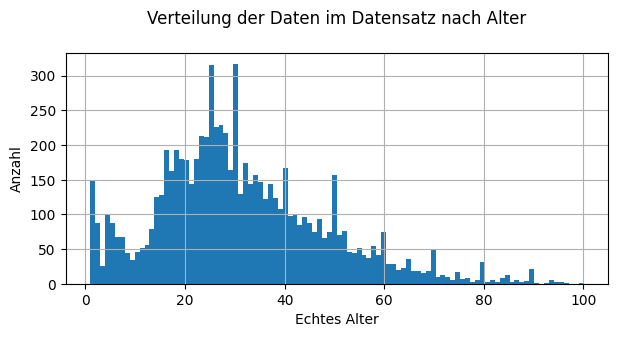

In [8]:
# Statistiken anzeigen
plt.figure(figsize=(7,3))
plt.title('Verteilung der Daten im Datensatz nach Alter\n')
plt.xlabel('Echtes Alter')
plt.ylabel('Anzahl')
df.real_age.hist(bins=100)

<Axes: title={'center': 'Boxplot für die realen Alterswerte\n'}, xlabel='Echtes Alter'>

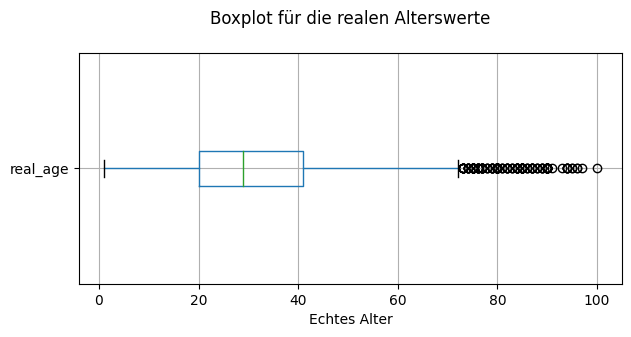

In [9]:
# Ausreißer überprüfen
plt.figure(figsize=(7,3))
plt.title('Boxplot für die realen Alterswerte\n')
plt.xlabel('Echtes Alter')
df.boxplot('real_age', vert=False)

Basierend auf dem Boxplot kann man sagen, dass ein Alter über 72 Jahren als untypisch betrachtet werden kann. Tatsächlich ist dies nicht der Fall. Es gibt offensichtlich sehr wenige Daten in dieser Altersgruppe.

Wir werden die Daten in Alterskategorien aufteilen und die Anzahl der Einträge vergleichen.

<Axes: title={'center': 'Verteilung der Daten nach Altersgruppen'}, ylabel='age_cat'>

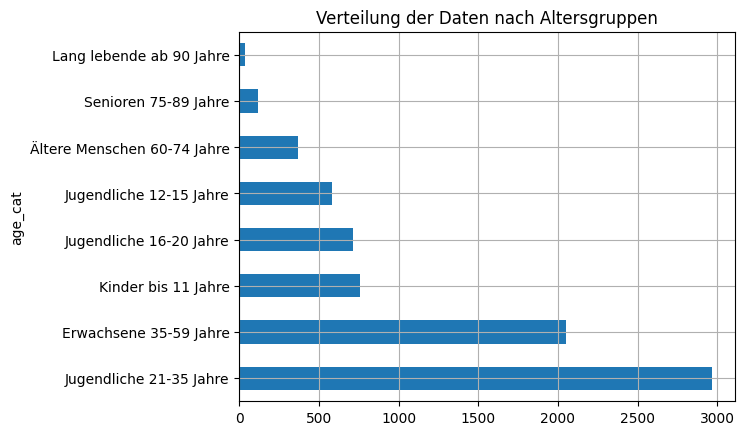

In [10]:
# Altersgruppen erstellen
df['age_cat'] = pd.cut(
    df.real_age,
    bins=[0, 11, 16, 20, 35, 59, 74, 89, 100],
    labels=['Kinder bis 11 Jahre', 'Jugendliche 12-15 Jahre', 'Jugendliche 16-20 Jahre',
            'Jugendliche 21-35 Jahre', 'Erwachsene 35-59 Jahre',
            'Ältere Menschen 60-74 Jahre', 'Senioren 75-89 Jahre',
            'Lang lebende ab 90 Jahre']
)
df.age_cat.value_counts().plot(
    kind='barh', grid=True,
    title='Verteilung der Daten nach Altersgruppen'
)

Ungleichgewicht in den Altersgruppen. Die meisten Daten fallen in den Altersbereich von 20 bis 59 Jahren. Es gibt weniger Fotos von Menschen über 60 Jahren. Drei Hauptgruppen können identifiziert werden.

In [11]:
# Anteile jeder der drei Gruppen
kinder = df['real_age'] < 21
erwachsene = (df['real_age'] >= 21) & (df['real_age'] < 60)
ältere_menschen = df['real_age'] >= 60

print(f'''
Anteil der Daten im Datensatz nach Altersgruppen:
      
1. Kinder: {kinder.mean():.2%}
2. Jugendliche und Erwachsene: {erwachsene.mean():.2%}
3. Ältere Menschen und Senioren: {ältere_menschen.mean():.2%}
''')


Anteil der Daten im Datensatz nach Altersgruppen:
      
1. Kinder: 27.06%
2. Jugendliche und Erwachsene: 66.08%
3. Ältere Menschen und Senioren: 6.86%



In [12]:
%%time
# Überprüfen der Existenz aller Dateien
lost_files = []
for i in df.index:
    file_name = df.iloc[i]['file_name']
    if not os.path.exists(os.path.join(faces_path, file_name)):
        lost_files.append([i, file_name])
# Verlorene Dateien anzeigen
lost_files

CPU times: user 1.14 s, sys: 334 ms, total: 1.47 s
Wall time: 25.5 s


[]

Es gibt keine verlorenen Dateien, alle Einträge haben zugeordnete Dateien.

Wir visualisieren einige zufällige Fotos und bewerten die Übereinstimmung des angegebenen Alters im Datensatz.

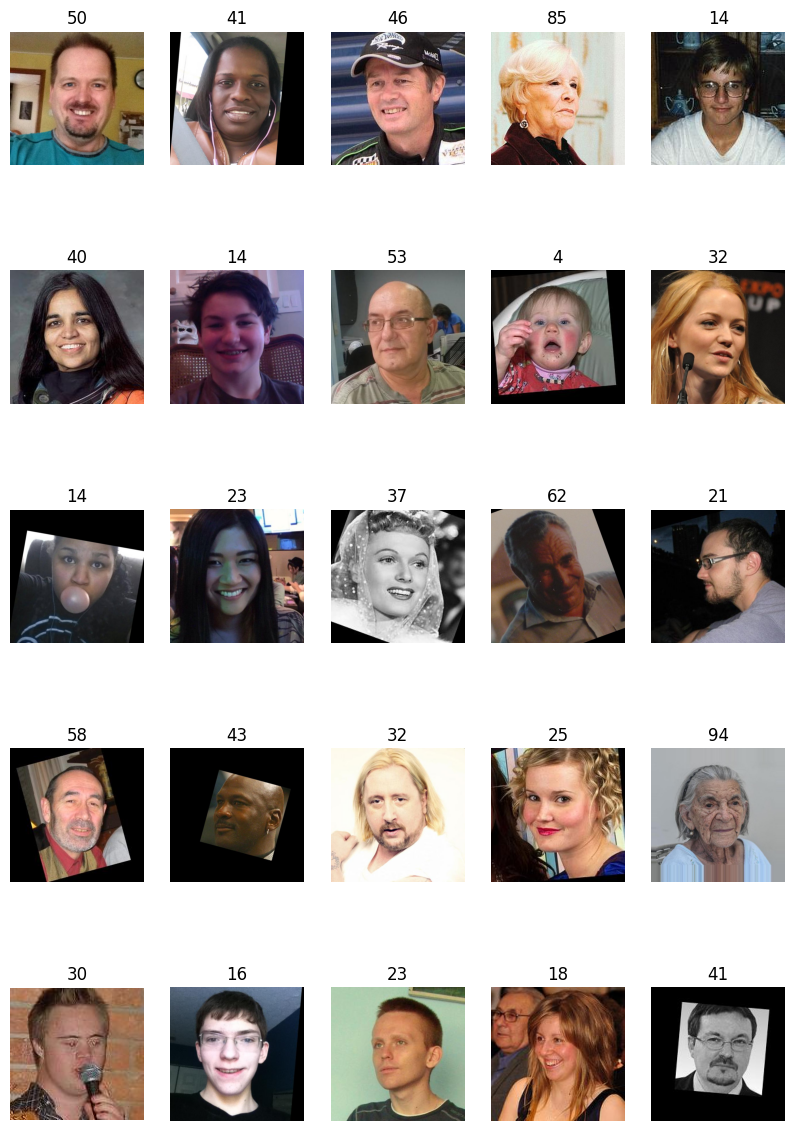

In [22]:
# Anzahl der Zeilen und Spalten
rows = 5
columns = 5

# Zufällige Daten auswählen
images = df.sample(rows*columns, random_state=12345)
# Bilder und Altersdaten anzeigen
fig = plt.figure(figsize=(10, 15))
for i in range(columns*rows):
    img = Image.open(os.path.join(faces_path, images.iloc[i]['file_name']))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(images.iloc[i]['real_age'])
plt.show()

### Zusammenfassung:

Wir haben Daten geladen und den Datensatz erforscht. Der Datensatz besteht aus zwei Teilen: einem Ordner mit Fotos von Menschen und einer CSV-Datei, die Dateinamen und das Alter der Person auf dem Foto enthält.

Insgesamt gibt es 7951 Dateien. Alle angegebenen Dateien sind im Ordner mit Bildern vorhanden, es gibt keine Lücken, und es wurden keine Duplikate gefunden.

Die Altersinformationen haben die folgenden Merkmale: Mindestalter 1 Jahr, Höchstalter 100 Jahre, Durchschnittsalter 31 Jahre, Medianalter 29 Jahre. Visuell entspricht das Alter der Personen auf den Fotos dem im Datensatz angegebenen Alter.

Die Daten können grob in 3 Gruppen unterteilt werden: Kinder, mittleres Alter und ältere Menschen. Es gibt ein starkes Ungleichgewicht nach Altersgruppen. Die meisten Fotos von Menschen im Alter von 21 bis 59 Jahren, etwa 66 %. Die wenigsten Daten von Menschen über 60 Jahren, etwas weniger als 7 %. Kinder machen etwa 27 % der Daten aus.

Somit haben wir einen ziemlich kleinen und unausgeglichenen Datensatz, was sich negativ auf das Modelltraining und dessen Qualität auswirken kann.

Es ist notwendig, die Anzahl der Kinderfotos zu erhöhen, sowie für ältere Menschen. Um das Ungleichgewicht zu reduzieren, können Sie die Augmentationstechnik für Bilder weniger repräsentierter Altersgruppen verwenden.

# Modelltraining
Wenn wir das Alter einer Person anhand ihres Fotos bestimmen, nennen wir eine Zahl aus einem kleinen Bereich. Um diese Aufgabe zu lösen, eignet sich ein Modell, das eine Regressionsaufgabe löst.

Neuronale Netzwerke arbeiten am besten mit Bildern. Wir werden die vortrainierte Architektur des Convolutional Neural Network ResNet50 verwenden, das auf dem ImageNet-Datensatz trainiert wurde. Dies ermöglicht eine Reduzierung der Trainingszeit und eine Einsparung von Rechenressourcen.

Für ResNet müssen wir die Ausgangsvollständig verbundene Schichten umgestalten, um die Regressionsaufgabe zu lösen. Am Ausgang des Netzwerks haben wir nur einen Neuronen mit der Aktivierungsfunktion ReLU. ReLU ändert positive Vorhersagen des Netzwerks nicht, setzt aber alle negativen auf null. Das Alter kann nicht unter 0 liegen.

Als Verlustfunktion verwenden wir den Mean Squared Error, der es dem Modell ermöglicht, schneller zu lernen.

Zur Bewertung der Modellqualität verwenden wir den Mean Absolute Error. Gemäß den Anforderungen der Aufgabe sollte sein Wert auf dem Testset 8 nicht überschreiten.

Wir erstellen folgende Funktionen:

* load_train(path) - Generator für das Trainingsset.
* load_test(path) - Generator für das Testset.
* create_model(input_shape) - Erstellen des Modells für das Convolutional Neural Network basierend auf der Architektur von ResNet50.
* train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps) - Modelltrainingsverfahren.

In [14]:
def load_train(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1.0/255, validation_split=0.25,
        horizontal_flip=True
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe,
        directory=path + '/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='training'
    )
    return train_datagen_flow

# Testdatengenerator erstellen
def load_test(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe,
        directory=path + '/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='validation'
    )
    return test_datagen_flow

# Modell erstellen
def create_model(input_shape):
    optimizer = Nadam(learning_rate=0.0002)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPool2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Modell trainieren
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    # Frühstoppbedingung basierend auf dem Verlustwert
    stop_loss = EarlyStopping(
        monitor='val_loss', patience=15,
        verbose=1, restore_best_weights=True
    )
    # Frühstoppbedingung basierend auf der Qualität der Metrik
    stop_mae = EarlyStopping(
        monitor='val_mae', patience=15,
        verbose=1, restore_best_weights=True
    )
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[stop_loss, stop_mae],
        verbose=2
    )
    return model

In [15]:
# Datensätze erstellen
path = '/kaggle/input/appa-real-face-cropped/'

train_data = load_train(path)
test_data = load_test(path)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [16]:
# Modell erstellen
model = create_model(input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [17]:
# Modell trainieren
history = train_model(
    model, train_data, test_data, batch_size=None, epochs=50,
    steps_per_epoch=None, validation_steps=None
)

Epoch 1/50
178/178 - 150s - loss: 158.8112 - mae: 9.5174 - val_loss: 921.9950 - val_mae: 25.5551 - 150s/epoch - 842ms/step
Epoch 2/50
178/178 - 72s - loss: 81.4304 - mae: 6.9086 - val_loss: 581.1785 - val_mae: 19.0661 - 72s/epoch - 404ms/step
Epoch 3/50
178/178 - 72s - loss: 53.2353 - mae: 5.5466 - val_loss: 387.9313 - val_mae: 14.5738 - 72s/epoch - 403ms/step
Epoch 4/50
178/178 - 72s - loss: 38.4136 - mae: 4.7348 - val_loss: 155.9227 - val_mae: 9.4607 - 72s/epoch - 403ms/step
Epoch 5/50
178/178 - 72s - loss: 29.2346 - mae: 4.1164 - val_loss: 141.9922 - val_mae: 9.4527 - 72s/epoch - 404ms/step
Epoch 6/50
178/178 - 72s - loss: 25.9276 - mae: 3.8518 - val_loss: 90.4672 - val_mae: 7.0177 - 72s/epoch - 403ms/step
Epoch 7/50
178/178 - 72s - loss: 23.0551 - mae: 3.6553 - val_loss: 74.7839 - val_mae: 6.3434 - 72s/epoch - 406ms/step
Epoch 8/50
178/178 - 72s - loss: 19.0510 - mae: 3.3368 - val_loss: 69.9315 - val_mae: 6.1905 - 72s/epoch - 403ms/step
Epoch 9/50
178/178 - 72s - loss: 17.5156 - ma

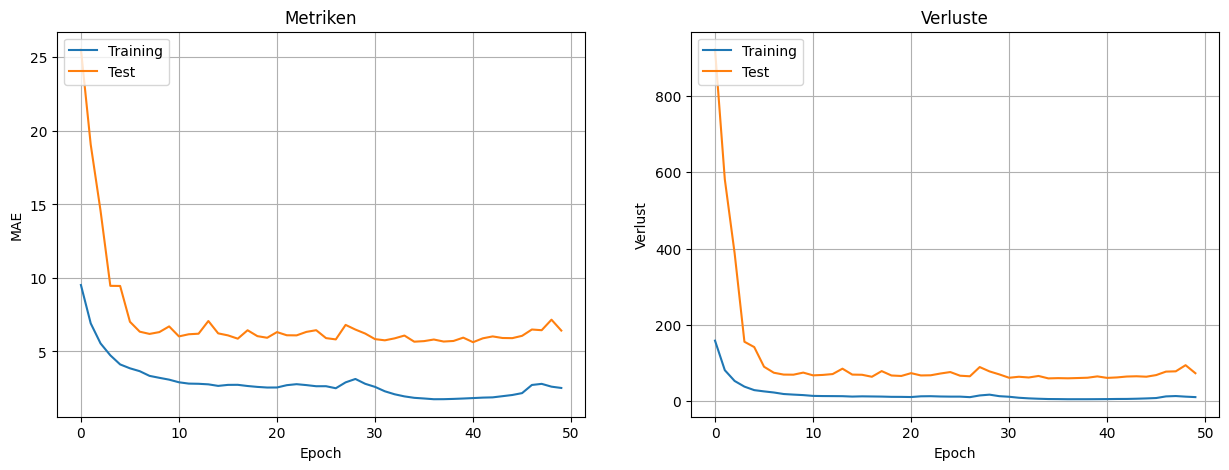

In [18]:
# Plotten wir die Trainingsprozessdiagramme
plt.figure(figsize=(15,5))

# Modelle Metriken
plt.subplot(1, 2, 1)
plt.plot(history.history.history['mae'])
plt.plot(history.history.history['val_mae'])
plt.grid(True)
plt.title('Metriken')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper left')

# Modelle Fehler
plt.subplot(1, 2, 2)
plt.plot(history.history.history['loss'])
plt.plot(history.history.history['val_loss'])
plt.grid(True)
plt.title('Verluste')
plt.ylabel('Verlust')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper left')
plt.show()

# Analyse des trainierten Modells
Wir erhalten einen Batch Testdaten und machen eine Vorhersage mit unserem trainierten Modell. Wir berechnen die Metrik, vergleichen das vorhergesagte und das tatsächliche Alter in Zahlen und visuell.

In [19]:
# nächster Batch Testdaten
features_test, target_test = next(test_data)

# Vorhersage des Modells auf den Batch-Daten
predicted = model.predict(features_test)

# Berechnen Sie MAE
mae = mean_absolute_error(target_test, predicted[:,0])

print(f'\nMAE-Wert für den Batch aus dem Testset: {mae.numpy():.3f}')

1/1 [==============================] - 1s 988ms/step

MAE-Wert für den Batch aus dem Testset: 5.238


In [20]:
# Vergleichen wir das tatsächliche und das vorhergesagte Alter
results = pd.DataFrame(target_test, columns=['Tatsächliches Alter'])

results['Vorhergesagtes Alter'] = pd.DataFrame(
round(pd.DataFrame(predicted, columns=['Vorhergesagtes Alter'])).astype('int')
)
results['Fehlergröße'] = results['Tatsächliches Alter'] - results['Vorhergesagtes Alter']

results

,Tatsächliches Alter,Vorhergesagtes Alter,Fehlergröße
0,28,31,-3
1,13,42,-29
2,33,40,-7
3,27,32,-5
4,36,35,1
5,38,31,7
6,27,27,0
7,10,13,-3
8,16,23,-7
9,27,30,-3


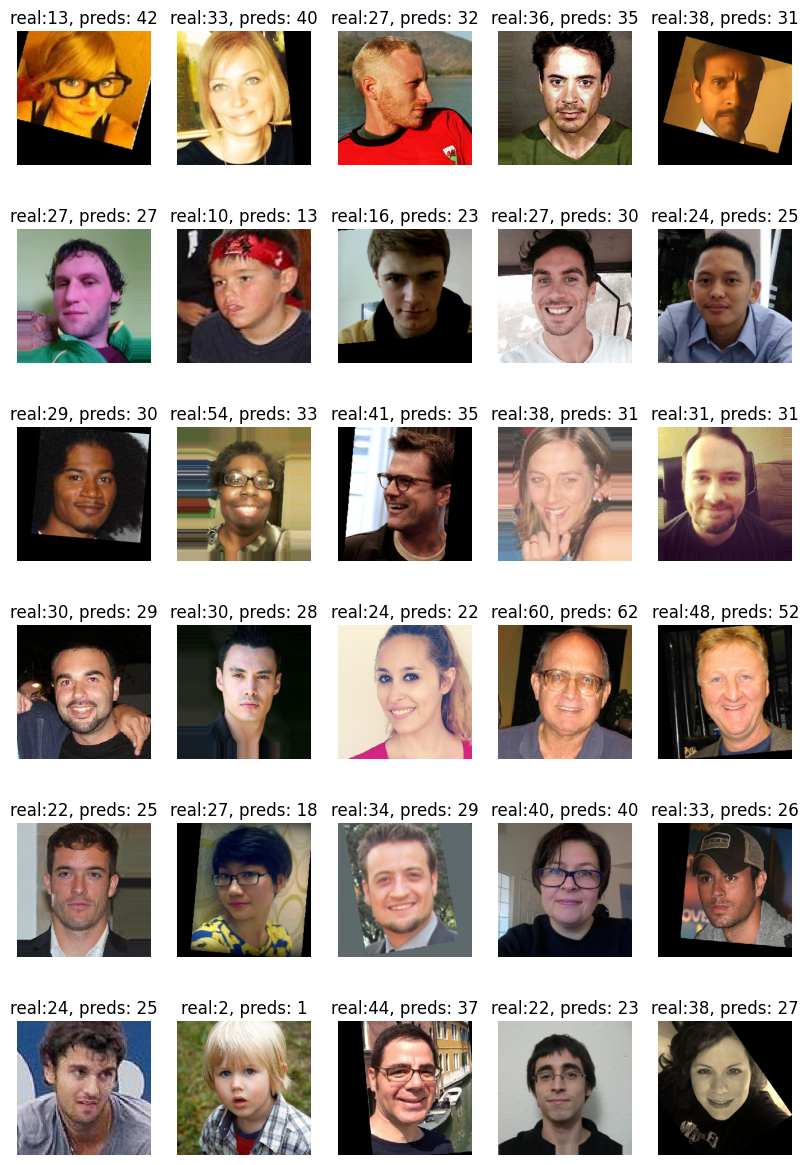

In [26]:
# Bilder und vorhergesagtes Alter anzeigen
columns = 5
rows = len(predicted) // columns
fig = plt.figure(figsize=(10,15))
for i in range(1,len(predicted)-1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(features_test[i])
    plt.axis('off')
    plt.title(f'real:{target_test[i]}, preds: {round(predicted[i][0])}')
plt.show()

In [28]:
# Durchschnittliches MAE für Untergruppen von Testdaten
mae = []
for i in range(len(test_data)):
    features_test, target_test = next(test_data)
    predicted = model.predict(features_test)
    mae.append((mean_absolute_error(target_test, predicted[:,0])).numpy())
print('\nDurchschnittlicher Wert für Untergruppen von Testdaten:', sum(mae) / len(mae))

1/1 [==============================] - 0s 35ms/step

Durchschnittlicher Wert für Untergruppen von Testdaten: 5.645292202631633


Wir haben das Modell trainiert und seine Leistung auf dem Testset überprüft. Der MAE-Wert betrug 5.65, was als ausgezeichnetes Ergebnis betrachtet werden kann.

Aber wir sehen, dass das Modell ziemlich stark sowohl in die eine als auch in die andere Richtung irren kann. Insbesondere sind solche Fehler bei Kindern deutlich sichtbar. Bei kleinen Alterswerten wird ein Fehler von 6 Jahren signifikant, während solche Fehler für reife Menschen und älter als nicht signifikant betrachtet werden können.

## Fazit
Wir haben ein Modell für einen Supermarkt entwickelt, das anhand eines Kundenfotos ungefähr sein Alter bestimmen kann.

Für die Umsetzung dieses Projekts haben wir eine explorative Datenanalyse des Fotosatzes durchgeführt und die Daten für das Training vorbereitet. Es gibt ein starkes Ungleichgewicht nach Altersgruppen. Der Anteil der Daten im Datensatz nach Altersgruppen:

1. Kinder: 27,06%
2. Jugendliche und Erwachsene: 66,08%
3. Ältere Menschen und Senioren: 6,86%

Der Datensatz wurde wie er ist verwendet. Aber in Zukunft könnte man den Datensatz erweitern, um das Ungleichgewicht zu beheben und die Qualität des Modells zu verbessern.
Als Grundlage für unser Modell haben wir die Architektur des Convolutional Neural Network ResNet verwendet, das auf dem ImageNet-Datensatz vortrainiert wurde. Dies ermöglichte es uns, die Trainingszeit unseres Modells zu verkürzen und somit die Rechenressourcen zu sparen.

Wir haben das trainierte Modell auf dem Testset überprüft. Der MAE-Wert betrug 5.46. Der vom Kunden festgelegte Mindestschwellenwert für die Metrik beträgt 8, daher können wir den Schluss ziehen, dass die Aufgabe erfolgreich abgeschlossen wurde.

Die Analyse zeigt, dass das Modell in der Lage ist, das Alter der Kunden mit einer bestimmten Genauigkeit zu bestimmen, aber relativ starke Fehler machen kann. Fehler sind besonders bei Kindern deutlich sichtbar, bei erwachsenen Menschen sind sie nicht so kritisch.